<a href="https://colab.research.google.com/github/FilippoMoro/SHD_Linear_Separability/blob/main/SHD_LogRegr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import h5py
import copy
import pickle
import numpy as np
import numpy.random as rd
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
from torchvision.ops import MLP
import time

# Import Logistic Regression from scikitlearn
from sklearn.linear_model import LogisticRegression

if torch.backends.mps.is_available():
    device = torch.device('mps')
    print( f'you are using a Mac-based GPU' )
elif torch.cuda.is_available():
    # device = torch.cuda.device(0)
    device = torch.device('cuda:0')
    print( 'You are using a '+str(torch.cuda.get_device_name(0)) )
else:
    device = torch.device('cpu')
    print( f'you are using a: {device}' )

you are using a: cpu


In [ ]:
# Reproducibility in RNG
seed = 14
torch.manual_seed( seed )
np.random.seed( seed )
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)

### 1. Load the Numpy dataloader
---

In [ ]:
import urllib.request
import gzip, shutil
import hashlib
from six.moves.urllib.error import HTTPError
from six.moves.urllib.error import URLError
from six.moves.urllib.request import urlretrieve

def get_audio_dataset(cache_dir, cache_subdir, dataset_name):
    # The remote directory with the data files
    base_url = "https://zenkelab.org/datasets"

    # Retrieve MD5 hashes from remote
    response = urllib.request.urlopen("%s/md5sums.txt"%base_url)
    data = response.read()
    lines = data.decode('utf-8').split("\n")
    file_hashes = { line.split()[1]:line.split()[0] for line in lines if len(line.split())==2 }

    # Download the Spiking Heidelberg Digits (SHD) dataset
    if dataset_name == 'shd':
        files = [ "shd_train.h5.gz", "shd_test.h5.gz"]
    if dataset_name == 'ssc':
        files = [ "ssc_train.h5.gz", "ssc_test.h5.gz"]
    if dataset_name == 'all':
        files = [ "shd_train.h5.gz", "shd_test.h5.gz", "ssc_train.h5.gz", "ssc_test.h5.gz"]

    for fn in files:
        origin = "%s/%s"%(base_url,fn)
        hdf5_file_path = get_and_gunzip(origin, fn, md5hash=file_hashes[fn], cache_dir=cache_dir, cache_subdir=cache_subdir)
        # print("File %s decompressed to:"%(fn))
        print("Available at: %s"%hdf5_file_path)

def get_and_gunzip(origin, filename, md5hash=None, cache_dir=None, cache_subdir=None):
    gz_file_path = get_file(filename, origin, md5_hash=md5hash, cache_dir=cache_dir, cache_subdir=cache_subdir)
    hdf5_file_path = gz_file_path[:-3]
    if not os.path.isfile(hdf5_file_path) or os.path.getctime(gz_file_path) > os.path.getctime(hdf5_file_path):
        print("Decompressing %s"%gz_file_path)
        with gzip.open(gz_file_path, 'r') as f_in, open(hdf5_file_path, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)
    return hdf5_file_path

def validate_file(fpath, file_hash, algorithm='auto', chunk_size=65535):
    if (algorithm == 'sha256') or (algorithm == 'auto' and len(file_hash) == 64):
        hasher = 'sha256'
    else:
        hasher = 'md5'

    if str(_hash_file(fpath, hasher, chunk_size)) == str(file_hash):
        return True
    else:
        return False

def _hash_file(fpath, algorithm='sha256', chunk_size=65535):
    if (algorithm == 'sha256') or (algorithm == 'auto' and len(hash) == 64):
        hasher = hashlib.sha256()
    else:
        hasher = hashlib.md5()

    with open(fpath, 'rb') as fpath_file:
        for chunk in iter(lambda: fpath_file.read(chunk_size), b''):
            hasher.update(chunk)

    return hasher.hexdigest()

def get_file(fname,
             origin,
             md5_hash=None,
             file_hash=None,
             cache_subdir='datasets',
             hash_algorithm='auto',
             extract=False,
             archive_format='auto',
             cache_dir=None):
    if cache_dir is None:
        cache_dir = os.path.join(os.path.expanduser('~'), '.data-cache')
    if md5_hash is not None and file_hash is None:
        file_hash = md5_hash
        hash_algorithm = 'md5'
    datadir_base = os.path.expanduser(cache_dir)
    if not os.access(datadir_base, os.W_OK):
        datadir_base = os.path.join('/tmp', '.data-cache')
    datadir = os.path.join(datadir_base, cache_subdir)

    # Create directories if they don't exist
    os.makedirs(cache_dir, exist_ok=True)
    os.makedirs(datadir, exist_ok=True)

    fpath = os.path.join(datadir, fname)

    download = False
    if os.path.exists(fpath):
    # File found; verify integrity if a hash was provided.
        if file_hash is not None:
            if not validate_file(fpath, file_hash, algorithm=hash_algorithm):
                print('A local file was found, but it seems to be '
                      'incomplete or outdated because the ' + hash_algorithm +
                      ' file hash does not match the original value of ' + file_hash +
                      ' so we will re-download the data.')
                download = True
    else:
        download = True

    if download:
        print('Downloading data from', origin)

        error_msg = 'URL fetch failure on {}: {} -- {}'
        try:
            try:
                urlretrieve(origin, fpath)
            except HTTPError as e:
                raise Exception(error_msg.format(origin, e.code, e.msg))
            except URLError as e:
                raise Exception(error_msg.format(origin, e.errno, e.reason))
        except (Exception, KeyboardInterrupt) as e:
            if os.path.exists(fpath):
                os.remove(fpath)

    return fpath

In [ ]:
# Numpy-based DataLoader
from torch.utils import data
from functools import partial

class dataset_numpy(data.Dataset):
    ''' Numpy based generator
    '''
    def __init__(self, spikes, labels, name, target_dim, nb_steps):
        self.nb_steps = nb_steps
        self.nb_units = 700
        self.max_time = 1.4
        self.spikes = spikes
        self.labels = labels
        self.name = name

        self.firing_times = self.spikes['times']
        self.units_fired  = self.spikes['units']
        self.num_samples = self.firing_times.shape[0]
        self.time_bins = np.linspace(0, self.max_time, num=self.nb_steps)

        self.input  = np.zeros((self.num_samples, self.nb_steps, self.nb_units), dtype=np.uint8)
        self.output = np.array(self.labels, dtype=np.uint8)

        self.load_spikes()
        self.reduce_inp_dimensions(target_dim=target_dim, axis=2)

    def __len__(self):
        return self.num_samples

    def load_spikes(self):
        for idx in range(self.num_samples):
            times = np.digitize(self.firing_times[idx], self.time_bins)
            units = self.units_fired[idx]
            if max(units)>=self.nb_units:
                units = np.clip(units, 0, self.nb_units-1)
                # print(idx)
            self.input[idx, times, units] = 1

    def reduce_inp_dimensions(self, target_dim, axis):
        sample_ind = int(np.ceil(self.nb_units / target_dim))
        index = [np.arange(i, 700, sample_ind) for i in range(sample_ind)]
        reshaped = [np.take(self.input, index[i], axis) for i in range(sample_ind)]
        reshaped = [np.pad(reshaped[i], [(0,0), (0,0), (0,int(target_dim-reshaped[i].shape[2]))], mode='constant') for i in range(sample_ind)]
        reshaped = np.concatenate(reshaped, axis=0)
        self.input = reshaped
        self.output = np.tile(self.output, sample_ind)
        self.num_samples = reshaped.shape[0]

    def __getitem__(self, idx):
        inputs, outputs = self.__data_generation(idx)
        return inputs, outputs

    def __data_generation(self, idx):
        if self.name == 'shd':
            output = self.output[idx]
        if self.name == 'ssc':
            output = self.output[idx] + 20
        return self.input[idx], output

def numpy_collate(batch):
  if isinstance(batch[0], np.ndarray):
    return np.stack(batch)
  elif isinstance(batch[0], (tuple,list)):
    transposed = zip(*batch)
    return [numpy_collate(samples) for samples in transposed]
  else:
    return np.array(batch)

class NumpyLoader(data.DataLoader):
  def __init__(self, dataset, batch_size=1,
                shuffle=True, sampler=None,
                batch_sampler=None, num_workers=0,
                pin_memory=False, drop_last=False,
                timeout=0, worker_init_fn=None):
    super(self.__class__, self).__init__(dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        sampler=sampler,
        batch_sampler=batch_sampler,
        num_workers=num_workers,
        collate_fn=numpy_collate,
        pin_memory=pin_memory,
        drop_last=drop_last,
        timeout=timeout,
        worker_init_fn=worker_init_fn)

#Download and preprocess
def get_numpy_datasets(dataset_name, n_inp, nb_steps):
    cache_dir = os.path.expanduser("~/data")
    cache_subdir = "audiospikes"
    get_audio_dataset(cache_dir, cache_subdir, dataset_name)

    train_ds = []; test_ds = []
    if dataset_name in ['shd', 'all']:
        train_shd_file = h5py.File(os.path.join(cache_dir, cache_subdir, 'shd_train.h5'), 'r')
        test_shd_file  = h5py.File(os.path.join(cache_dir, cache_subdir, 'shd_test.h5'), 'r')
        shd_train_ds = dataset_numpy(train_shd_file['spikes'], train_shd_file['labels'], name='shd', target_dim=n_inp, nb_steps=nb_steps)
        shd_test_ds  = dataset_numpy(test_shd_file['spikes'], test_shd_file['labels'], name='shd', target_dim=n_inp, nb_steps=nb_steps)
        train_ds.append(shd_train_ds)
        test_ds.append(shd_test_ds)

    return train_ds, test_ds

In [ ]:
dataset_name= "shd"
cache_dir = os.path.expanduser(os.getcwd()+"/data") #os.path.expanduser("~/data")
cache_subdir = "audiospikes"
get_audio_dataset(cache_dir, cache_subdir, dataset_name)

Available at: /content/data/audiospikes/shd_train.h5
Available at: /content/data/audiospikes/shd_test.h5


### 2. Training Algorithm
---

In [ ]:
def training_SHD( epochs, model, lr, weight_decay, x_train, batch_size, x_test, device, scheduler=None,
                  optimizer=None, keep_2D=False, verbose=True ):
    model = model.to(device)
    if optimizer is None:
        optimizer = torch.optim.SGD( model.parameters(), lr=lr, weight_decay=weight_decay )
    loss_func = torch.nn.CrossEntropyLoss(  )
    tot_iters = 10
    if scheduler is None:
        scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.01, total_iters=tot_iters, last_epoch=-1, verbose=False)
    train_losses, train_accs = [], []
    for e in range(epochs):
        correct, samples, batch_num = 0, 0, 0
        train_loss_epoch = 0
        for x_local, y_local in x_train:
            if keep_2D: X = torch.from_numpy(x_local)
            else: X = torch.from_numpy(x_local).reshape(batch_size,-1)
            X = X.to(device).type(torch.float); y_local = torch.from_numpy(y_local).to(device)
            optimizer.zero_grad()
            y_tilde = model( X )
            y_titlde = torch.nn.functional.softmax(y_tilde, dim=1)
            loss = loss_func( y_titlde, y_local )
            loss.backward()
            optimizer.step()
            correct += torch.sum( (torch.argmax(y_tilde, dim=1) == y_local).type(torch.float) )
            samples += y_local.shape[0]
            train_loss_epoch += loss.item()
            batch_num += 1
        train_acc = correct/samples
        mean_loss = train_loss_epoch/batch_num
        train_losses.append( mean_loss )
        train_accs.append( train_acc.item() )
        if verbose: print(f'Epoch {e+1}, Train Acc: {train_acc*100:.2f}, Train Loss: {mean_loss:.4f}')
        if e+1 % int((epochs)/tot_iters) == 0:
            scheduler.step()
            # scheduler.step(mean_loss)
            # last_lr = scheduler.get_last_lr()

    with torch.no_grad():
        test_loss = 0
        for x_local, y_local in x_test:
            if keep_2D: X = torch.from_numpy(x_local)
            else: X = torch.from_numpy(x_local).reshape(batch_size,-1)
            X = X.to(device).type(torch.float); y_local = torch.from_numpy(y_local).to(device)
            y_tilde = model( X )
            y_titlde = torch.nn.functional.softmax(y_tilde, dim=1)
            loss = loss_func( y_titlde, y_local )
            correct += torch.sum( (torch.argmax(y_tilde, dim=1) == y_local).type(torch.float) )
            samples += y_local.shape[0]
            test_loss += loss.item()
    test_acc = correct/samples
    test_loss = test_loss/samples
    if verbose: print(f'Epoch {e+1}, Test Acc: {test_acc*100:.2f}')

    return [train_losses, train_accs], [test_loss, test_acc.item()]


# 3. Linear Separbility of SHD
---
We'll use a simple Logistic Regression algorithm to classify the SHD dataset.

Contrary to the "conventional" way of process temporal sequences, which implies processing inputs in a streaming fashion, we'll store the whole input sequence in memory.

Then, we will be looking at the whole information contained in a datapoint at once. Such a datapoint has 'num_channels' input channels and different 'time_step' entries --> as a consequence, the input size is:

$   n\_input = num\_channels \cdot time\_step$

Such input is processed with Logistic Regression, thus with a single-layer neural network, or perceptron. We'll use the "Linear" module from Pytorch for this model.

Solving such task with Logistic Regression will provide a reference for the Linear Separability of SHD, i.e. the classification accuracy obtained with a Linear Model.

In [ ]:
max_time = 1.4
time_steps = 512
dt = max_time/time_steps
batch_size = 128
num_channels = 700
epochs = 150
lr = 1e-1
weight_decay = 2e-4
tot_iters = 10
# Loading the dataset with the desired format/sizes
train_ds, test_ds = get_numpy_datasets(dataset_name='shd', nb_steps=time_steps, n_inp=num_channels)
train_dl = NumpyLoader(train_ds[0], batch_size=batch_size, num_workers=0, drop_last=True)
test_dl = NumpyLoader(test_ds[0], batch_size=batch_size, num_workers=0, drop_last=True)
# defining the model and the optimization algo
model = torch.nn.Linear( in_features=(num_channels*time_steps), out_features=20 ).to(device)
optimizer =torch.optim.SGD( model.parameters(), lr=lr, weight_decay=weight_decay )
scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.5, total_iters=tot_iters, last_epoch=-1, verbose=False)

[train_losses, train_accs], [test_loss, test_acc] = training_SHD( epochs, model, lr, weight_decay, train_dl, batch_size, test_dl, device,
                                                                  optimizer=optimizer, scheduler=scheduler, verbose=True )

Available at: /root/data/audiospikes/shd_train.h5
Available at: /root/data/audiospikes/shd_test.h5
Epoch 1, Train Acc: 27.52, Train Loss: 2.8365
Epoch 2, Train Acc: 46.43, Train Loss: 2.6525
Epoch 3, Train Acc: 54.54, Train Loss: 2.5589
Epoch 4, Train Acc: 58.48, Train Loss: 2.5154
Epoch 5, Train Acc: 61.83, Train Loss: 2.4819


In [ ]:
root = '/Users/filippomoro/Documents/Jupyter_Notebooks_old/Delay_computation/Results'
file_name = root + '/LR_max_acc.plk'

dict_lr_max = {
    'accs_test' : test_acc,
    'accs_train' : train_accs[-1],
    'max_time' : max_time,
    'time_steps' : time_steps,
    'num_channels' : num_channels,
    'epochs' : epochs,
    'lr' : lr
}

import pickle
pickle.dump( dict_lr_max, open( file_name, 'wb' ) )

### Impact of the number of Input Channels
---

In [ ]:
max_time = 1.4
time_steps = 256
dt = max_time/time_steps
batch_size = 128
epochs = 150
lr = 1e-1
tot_iters = 10
weight_decay = 2e-4

# list of number of inputs
reps = 5
num_channels_list = [700, 256, 128, 64]

# results
accs_num_channels_test, accs_num_channels_train = [], []
for n, num_channels in enumerate( num_channels_list ):
    accs_tmp = []; accs_train_tmp =[]
    print(f'-- Num Channels {num_channels}')
    # Loading the dataset with the desired format/sizes
    train_ds, test_ds = get_numpy_datasets(dataset_name='shd', nb_steps=time_steps, n_inp=num_channels)
    train_dl = NumpyLoader(train_ds[0], batch_size=batch_size, num_workers=0, drop_last=True)
    test_dl = NumpyLoader(test_ds[0], batch_size=batch_size, num_workers=0, drop_last=True)
    for r in range(reps):
        # initializing a new model
        model = torch.nn.Linear( in_features=(num_channels*time_steps), out_features=20 ).to(device)
        optimizer =torch.optim.SGD( model.parameters(), lr=lr, weight_decay=weight_decay )
        scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.5, total_iters=tot_iters, last_epoch=-1, verbose=False)
        # training the model
        [train_losses, train_accs], [test_loss, test_acc] = training_SHD( epochs, model, lr, weight_decay, train_dl, batch_size, test_dl, device,
                                                                            optimizer=optimizer, scheduler=scheduler, verbose=False )
        # collecting the results
        print(f'    Rep {r}, Test Accuracy {test_acc*100:.2f}%')
        accs_tmp.append( test_acc )
        accs_train_tmp.append( train_accs[-1] )
    accs_num_channels_test.append( accs_tmp )
    accs_num_channels_train.append( accs_train_tmp )

-- Num Channels 700
Available at: /root/data/audiospikes/shd_train.h5
Available at: /root/data/audiospikes/shd_test.h5
    Rep 0, Test Accuracy 88.92%
    Rep 1, Test Accuracy 93.29%
    Rep 2, Test Accuracy 93.40%
    Rep 3, Test Accuracy 92.90%
    Rep 4, Test Accuracy 92.89%
-- Num Channels 256
Available at: /root/data/audiospikes/shd_train.h5
Available at: /root/data/audiospikes/shd_test.h5
    Rep 0, Test Accuracy 83.71%
    Rep 1, Test Accuracy 79.25%
    Rep 2, Test Accuracy 83.70%
    Rep 3, Test Accuracy 83.72%
    Rep 4, Test Accuracy 74.65%
-- Num Channels 128
Available at: /root/data/audiospikes/shd_train.h5
Available at: /root/data/audiospikes/shd_test.h5
    Rep 0, Test Accuracy 83.22%
    Rep 1, Test Accuracy 76.52%
    Rep 2, Test Accuracy 79.71%
    Rep 3, Test Accuracy 80.79%
    Rep 4, Test Accuracy 79.24%
-- Num Channels 64
Available at: /root/data/audiospikes/shd_train.h5
Available at: /root/data/audiospikes/shd_test.h5
    Rep 0, Test Accuracy 78.98%
    Rep 1, Te

In [ ]:
root = '/content/drive/MyDrive/Colab Notebooks/Delay_computation/Results'
file_name = root + '/LR_num_channels_2.plk'

dict_lr_num_channels = {
    'accs_test' : np.array(accs_num_channels_test),
    'accs_train' : np.array(accs_num_channels_train),
    'num_channels_list' : num_channels_list,
    'max_time' : max_time,
    'time_steps' : time_steps,
    'num_channels' : num_channels,
    'epochs' : epochs,
    'lr' : lr
}

import pickle
pickle.dump( dict_lr_num_channels, open( file_name, 'wb' ) )

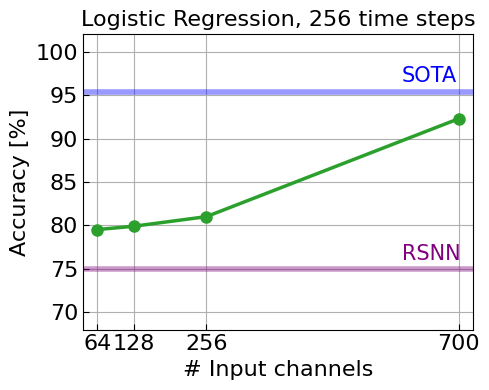

In [ ]:
# Load and plot the results
root = '/content/drive/MyDrive/Colab Notebooks/Delay_computation/Results'
file_name = root + '/LR_num_channels_2.plk'

import pickle
dict_load = pickle.load( open( file_name, 'rb' ) )

accs_test = np.array( dict_load['accs_test'] )#.reshape(-1,1)
accs_train = np.array( dict_load['accs_train'] )#.reshape(-1,1)
time_steps = np.array( dict_load['time_steps'] )
num_channels_list = np.array( dict_load['num_channels_list'] )

fig, ax = plt.subplots( figsize=(5, 4) )
ax.plot( num_channels_list, 1e2*np.mean( accs_test, axis=1 ), color='tab:green', lw=2.5, marker='o', markersize=8 )
ax.set_xticks( num_channels_list )
ax.hlines( 75.0, -1e5, 1e5, color='purple', alpha=0.4, lw=4 )
ax.hlines( 95.4, -1e5, 1e5, color='blue', alpha=0.4, lw=4 )
ax.set_xlabel( '# Input channels', size=16 )
ax.set_ylabel( 'Accuracy [%]', size=16 )
ax.set_title( f'Logistic Regression, {time_steps} time steps', size=16 )
ax.tick_params( direction='in', labelsize=16, size=4 )
ax.set_xlim( min(num_channels_list)-25, max(num_channels_list)+25 )
ax.set_yticks( np.arange(70, 105, 5) )
ax.set_ylim( 68, 102 )
ax.text( 600, 96.5, 'SOTA', color='blue', size=15 )
ax.text( 600, 76, 'RSNN', color='purple', size=15 )
ax.grid()
plt.tight_layout()
fig.savefig( root+'/LR_num_chanels_2.pdf', dpi=300, transparent=False )

### Impact of the number of Time steps
---

In [ ]:
max_time = 1.4
batch_size = 128
epochs = 100
lr = 1e-1
weight_decay = 2e-4
num_channels = 700
tot_iters = 10
# list of number of inputs
reps = 5
time_steps_list =  [512, 256, 128, 64] #[250, 64, 128, 512]

# results
accs_time_steps_test, accs_time_steps_train = [], []
for n, time_steps in enumerate( time_steps_list ):
    print(f'-- Num Time Steps {time_steps}')
    train_tmp, test_tmp = [], []
    # Loading the dataset with the desired format/sizes
    train_ds, test_ds = get_numpy_datasets(dataset_name='shd', nb_steps=time_steps, n_inp=num_channels)
    train_dl = NumpyLoader(train_ds[0], batch_size=batch_size, num_workers=0, drop_last=True)
    test_dl = NumpyLoader(test_ds[0], batch_size=batch_size, num_workers=0, drop_last=True)
    for r in range(reps):
        # initializing a new model
        model = torch.nn.Linear( in_features=(num_channels*time_steps), out_features=20 ).to(device)
        optimizer =torch.optim.SGD( model.parameters(), lr=lr, weight_decay=weight_decay )
        scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.1, total_iters=tot_iters, last_epoch=-1, verbose=False)
        # training the model
        [train_losses, train_accs], [test_loss, test_acc] = training_SHD( epochs, model, lr, weight_decay, train_dl, batch_size, test_dl, device,
                                                                            optimizer=optimizer, scheduler=scheduler, verbose=False )
        # collecting the results
        test_tmp.append( test_acc )
        train_tmp.append( train_accs[-1] )
        print(f'    Rep {r}, Test Accuracy {test_acc*100:.2f}')
    accs_time_steps_test.append( test_tmp )
    accs_time_steps_train.append( train_tmp )

-- Num Time Steps 512
Decompressing /root/data/audiospikes/shd_train.h5.gz
Available at: /root/data/audiospikes/shd_train.h5
Available at: /root/data/audiospikes/shd_test.h5


In [ ]:
root = '/content/drive/MyDrive/Colab Notebooks/Delay_computation/Results'
file_name = root + '/LR_time_steps_2.plk'

dict_lr_time_steps = {
    'accs_test' : accs_time_steps_test,
    'accs_train' : accs_time_steps_train,
    'num_channels' : num_channels,
    'time_steps_list' : time_steps_list,
    'max_time' : max_time,
    'time_steps' : time_steps,
    'epochs' : epochs,
    'lr' : lr
}

import pickle
pickle.dump( dict_lr_time_steps, open( file_name, 'wb' ) )

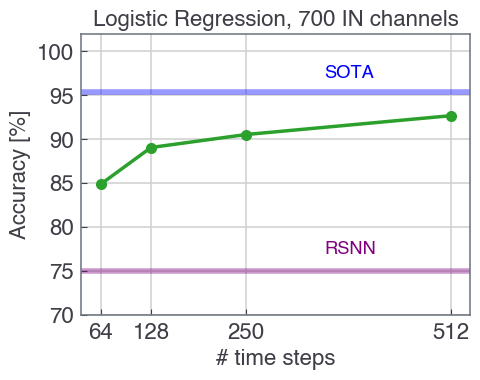

In [ ]:
# Load and plot the results
root = '/content/drive/MyDrive/Colab Notebooks/Delay_computation/Results'
file_name = root + '/LR_time_steps_2.plk'

import pickle
dict_load = pickle.load( open( file_name, 'rb' ) )

accs_test = np.array( dict_load['accs_test'] )
accs_train = np.array( dict_load['accs_train'] )
num_channels = np.array( dict_load['num_channels'] )
time_steps_list = np.array( dict_load['time_steps_list'] )

fig, ax = plt.subplots( figsize=(5, 4) )
# ax.plot( time_steps_list[[1,2,0,3]], 1e2*np.mean( accs_test, axis=1 )[[1,2,0,3]], color='tab:green', lw=2.5, marker='o', markersize=8 )
# ax.set_xticks( time_steps_list[[1,2,0,3]] )
ax.plot( time_steps_list, 1e2*np.mean( accs_test, axis=1 ), color='tab:green', lw=2.5, marker='o', markersize=8 )
ax.set_xticks( time_steps_list )
ax.hlines( 75.0, -1e5, 1e5, color='purple', alpha=0.4, lw=4 )
ax.hlines( 95.4, -1e5, 1e5, color='blue', alpha=0.4, lw=4 )
ax.set_xlabel( '# time steps', size=16 )
ax.set_ylabel( 'Accuracy [%]', size=16 )
ax.set_title( f'Logistic Regression, {num_channels} IN channels', size=16 )
ax.tick_params( direction='in', labelsize=16, size=4 )
ax.set_xlim( min(time_steps_list)-25, max(time_steps_list)+25 )
ax.set_ylim( 72, 102 )
ax.set_yticks( np.arange(70, 105, 5) )
ax.text( 350, 97, 'SOTA', color='blue' )
ax.text( 350, 77, 'RSNN', color='purple' )

plt.tight_layout()
fig.savefig( root+'/LR_time_steps_2.pdf', dpi=300, transparent=False )

# 3. SHD classification with MLP
---

In [ ]:
max_time = 1.4
time_steps = 256
num_channels = 256
batch_size = 128
epochs = 20
lr = 1e-3
weight_decay = 2e-4
# Loading the dataset with the desired format/sizes
train_ds, test_ds = get_numpy_datasets(dataset_name='shd', nb_steps=time_steps, n_inp=num_channels)
train_dl = NumpyLoader(train_ds[0], batch_size=batch_size, num_workers=0, drop_last=True)
test_dl = NumpyLoader(test_ds[0], batch_size=batch_size, num_workers=0, drop_last=True)
# Defining the model
model = MLP( in_channels=num_channels*time_steps, hidden_channels=[1048, 20], norm_layer=torch.nn.BatchNorm1d , activation_layer=torch.nn.ReLU )
optimizer =torch.optim.Adam( model.parameters(), lr=lr, weight_decay=weight_decay )
scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.1, total_iters=10, last_epoch=-1, verbose=False)

[train_losses, train_accs], [test_loss, test_acc] = training_SHD( epochs, model, lr, weight_decay, train_dl, batch_size, test_dl, device,
                                                                  optimizer=optimizer, scheduler=scheduler, verbose=True )



Epoch 1, Train Acc: 77.05, Train Loss: 2.3496
Epoch 2, Train Acc: 94.38, Train Loss: 2.1567
Epoch 3, Train Acc: 96.03, Train Loss: 2.1377
Epoch 4, Train Acc: 96.36, Train Loss: 2.1345
Epoch 5, Train Acc: 96.61, Train Loss: 2.1310
Epoch 6, Train Acc: 96.76, Train Loss: 2.1291
Epoch 7, Train Acc: 97.06, Train Loss: 2.1256
Epoch 8, Train Acc: 97.44, Train Loss: 2.1227
Epoch 9, Train Acc: 97.77, Train Loss: 2.1171
Epoch 10, Train Acc: 97.68, Train Loss: 2.1189
Epoch 11, Train Acc: 98.05, Train Loss: 2.1140
Epoch 12, Train Acc: 97.91, Train Loss: 2.1153
Epoch 13, Train Acc: 98.15, Train Loss: 2.1130
Epoch 14, Train Acc: 98.25, Train Loss: 2.1111
Epoch 15, Train Acc: 98.12, Train Loss: 2.1122
Epoch 16, Train Acc: 98.50, Train Loss: 2.1076
Epoch 17, Train Acc: 98.48, Train Loss: 2.1073
Epoch 18, Train Acc: 98.67, Train Loss: 2.1055
Epoch 19, Train Acc: 98.54, Train Loss: 2.1061
Epoch 20, Train Acc: 98.64, Train Loss: 2.1047
Epoch 20, Test Acc: 93.80


### MLP: hidden layer size

In [ ]:
max_time = 1.4
time_steps = 256
num_channels = 256
batch_size = 128
epochs = 60
lr = 1e-1
weight_decay = 1e-4

# list of number of inputs
reps = 5
hidden_size_list = [128, 512, 1024, 2048]

# Loading the dataset with the desired format/sizes
train_ds, test_ds = get_numpy_datasets(dataset_name='shd', nb_steps=time_steps, n_inp=num_channels)
train_dl = NumpyLoader(train_ds[0], batch_size=batch_size, num_workers=0, drop_last=True)
test_dl = NumpyLoader(test_ds[0], batch_size=batch_size, num_workers=0, drop_last=True)

# results
accs_test, accs_train = [], []
for n, hidden_size in enumerate( hidden_size_list ):
    print(f'-- Num Hidden Size {hidden_size}')
    for r in range(reps):
        # initializing a new model
        model = MLP( in_channels=num_channels*time_steps, hidden_channels=[hidden_size, 20], norm_layer=torch.nn.BatchNorm1d , activation_layer=torch.nn.ReLU )
        optimizer =torch.optim.Adam( model.parameters(), lr=lr, weight_decay=weight_decay )
        scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.1, total_iters=10, last_epoch=-1, verbose=False)
        # training the model
        [train_losses, train_accs], [test_loss, test_acc] = training_SHD( epochs, model, lr, weight_decay, train_dl, batch_size, test_dl, device,
                                                                            optimizer=optimizer, scheduler=scheduler, verbose=True )
        # collecting the results
        accs_test.append( test_acc )
        accs_train.append( train_accs[-1] )
        print(f'    Rep {r}, Test Accuracy {test_acc*100:.2f}')

-- Num Hidden Size 128


/var/folders/gr/cpg6p4_95b3fghclqyk0n2d00000gn/T/ipykernel_4627/3238180856.py:41: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1678176539774/work/torch/csrc/utils/tensor_new.cpp:591.)
  X_batch = torch.sparse.FloatTensor(i, v, torch.Size([batch_size,nb_steps,nb_units])).to(device)


    Rep 0, Test Accuracy 91.79
-- Num Hidden Size 512
    Rep 0, Test Accuracy 93.34
-- Num Hidden Size 1024
    Rep 0, Test Accuracy 94.17
-- Num Hidden Size 2048
    Rep 0, Test Accuracy 94.83


In [ ]:
root = '/content/drive/MyDrive/Colab Notebooks/Delay_computation/Results'
file_name = root + '/MLP_hidden_sizes.plk'

dict_mlp_hidden_sizes = {
    'accs_test' : accs_test,
    'accs_train' : accs_train,
    'hidden_size_list' : hidden_size_list,
    'max_time' : max_time,
    'time_steps' : time_steps,
    'num_channels' : num_channels,
    'epochs' : epochs,
    'lr' : lr
}

import pickle
pickle.dump( dict_mlp_hidden_sizes, open( file_name, 'wb' ) )

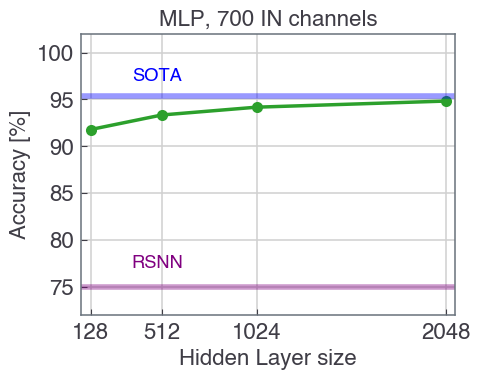

In [ ]:
# Load and plot the results
root = '/content/drive/MyDrive/Colab Notebooks/Delay_computation/Results'
file_name = root + '/MLP_hidden_sizes.plk'

import pickle
dict_load = pickle.load( open( file_name, 'rb' ) )

accs_test = np.array( dict_load['accs_test'] ).reshape(-1,1)
accs_train = np.array( dict_load['accs_train'] ).reshape(-1,1)
num_channels = np.array( dict_load['num_channels'] )
time_steps = np.array( dict_load['time_steps'] )
hidden_size_list = np.array( dict_load['hidden_size_list'] )

fig, ax = plt.subplots( figsize=(5, 4) )
ax.plot( hidden_size_list, 1e2*np.mean( accs_test, axis=1 ), color='tab:green', lw=2.5, marker='o', markersize=8 )
ax.set_xticks( hidden_size_list )
ax.hlines( 75.0, -1e5, 1e5, color='purple', alpha=0.4, lw=4 )
ax.hlines( 95.4, -1e5, 1e5, color='blue', alpha=0.4, lw=4 )
ax.set_xlabel( 'Hidden Layer size', size=16 )
ax.set_ylabel( 'Accuracy [%]', size=16 )
ax.set_title( f'MLP, {num_channels} IN channels', size=16 )
ax.tick_params( direction='in', labelsize=16, size=4 )
ax.set_xlim( min(hidden_size_list)-50, max(hidden_size_list)+50 )
ax.set_ylim( 72, 102 )
ax.set_yticks( np.arange(75, 105, 5) )
ax.text( 350, 97, 'SOTA', color='blue' )
ax.text( 350, 77, 'RSNN', color='purple' )

plt.tight_layout()
fig.savefig( root+'/MLP_hidden_size.pdf', dpi=300, transparent=False )

### MLP: input size

In [ ]:
max_time = 1.4
time_steps = 250
num_channels = 700
batch_size = 128
epochs = 40
lr = 1e-1
weight_decay = 1e-4
hidden_size = 1024

# list of number of inputs
reps = 1
num_channels_list = [64, 128, 256, 700]

# results
accs_test, accs_train = [], []
for n, num_channels in enumerate( num_channels_list ):
    print(f'-- Num Input Channels {num_channels}')
    # dataset definition
    train_ds, test_ds = get_numpy_datasets(dataset_name='shd', nb_steps=time_steps, n_inp=num_channels)
    train_dl = NumpyLoader(train_ds[0], batch_size=batch_size, num_workers=0, drop_last=True)
    test_dl = NumpyLoader(test_ds[0], batch_size=batch_size, num_workers=0, drop_last=True)
    for r in range(reps):
        # initializing a new model
        model = MLP( in_channels=num_channels*time_steps, hidden_channels=[hidden_size, 20], norm_layer=torch.nn.BatchNorm1d , activation_layer=torch.nn.ReLU )
        optimizer =torch.optim.Adam( model.parameters(), lr=lr, weight_decay=weight_decay )
        scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.1, total_iters=10, last_epoch=-1, verbose=False)
        # training the model
        [train_losses, train_accs], [test_loss, test_acc] = training_SHD( epochs, model, lr, weight_decay, train_dl, batch_size, test_dl, device,
                                                                            optimizer=optimizer, scheduler=scheduler, verbose=True )
        # collecting the results
        accs_test.append( test_acc )
        accs_train.append( train_accs[-1] )
        print(f'    Rep {r}, Test Accuracy {test_acc*100:.2f}')

-- Num Input Channels 64


/var/folders/gr/cpg6p4_95b3fghclqyk0n2d00000gn/T/ipykernel_5757/3238180856.py:41: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1678176539774/work/torch/csrc/utils/tensor_new.cpp:591.)
  X_batch = torch.sparse.FloatTensor(i, v, torch.Size([batch_size,nb_steps,nb_units])).to(device)


    Rep 0, Test Accuracy 83.74
-- Num Input Channels 128
    Rep 0, Test Accuracy 84.67
-- Num Input Channels 256
    Rep 0, Test Accuracy 91.01
-- Num Input Channels 700
    Rep 0, Test Accuracy 94.01


In [ ]:
root = '/content/drive/MyDrive/Colab Notebooks/Delay_computation/Results'
file_name = root + '/MLP_num_channels.plk'

dict_mlp_num_channels = {
    'accs_test' : accs_test,
    'accs_train' : accs_train,
    'num_channels_list' : num_channels_list,
    'max_time' : max_time,
    'time_steps' : time_steps,
    'hidden_size' : hidden_size,
    'epochs' : epochs,
    'lr' : lr
}

import pickle
pickle.dump( dict_mlp_num_channels, open( file_name, 'wb' ) )

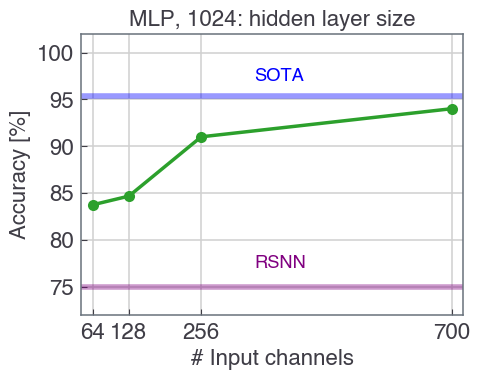

In [ ]:
# Load and plot the results
root = '/content/drive/MyDrive/Colab Notebooks/Delay_computation/Results'
file_name = root + '/MLP_num_channels.plk'

import pickle
dict_load = pickle.load( open( file_name, 'rb' ) )

accs_test = np.array( dict_load['accs_test'] ).reshape(-1,1)
accs_train = np.array( dict_load['accs_train'] ).reshape(-1,1)
time_steps = np.array( dict_load['time_steps'] )
hidden_size = np.array( dict_load['hidden_size'] )
num_channels_list = np.array( dict_load['num_channels_list'] )

fig, ax = plt.subplots( figsize=(5, 4) )
ax.plot( num_channels_list, 1e2*np.mean( accs_test, axis=1 ), color='tab:green', lw=2.5, marker='o', markersize=8 )
ax.set_xticks( num_channels_list )
ax.hlines( 75.0, -1e5, 1e5, color='purple', alpha=0.4, lw=4 )
ax.hlines( 95.4, -1e5, 1e5, color='blue', alpha=0.4, lw=4 )
ax.set_xlabel( '# Input channels', size=16 )
ax.set_ylabel( 'Accuracy [%]', size=16 )
ax.set_title( f'MLP, {hidden_size}: hidden layer size', size=16 )
ax.tick_params( direction='in', labelsize=16, size=4 )
ax.set_xlim( min(num_channels_list)-20, max(num_channels_list)+20 )
ax.set_ylim( 72, 102 )
ax.set_yticks( np.arange(75, 105, 5) )
ax.text( 350, 97, 'SOTA', color='blue' )
ax.text( 350, 77, 'RSNN', color='purple' )

plt.tight_layout()
fig.savefig( root+'/MLP_num_channels.pdf', dpi=300, transparent=False )

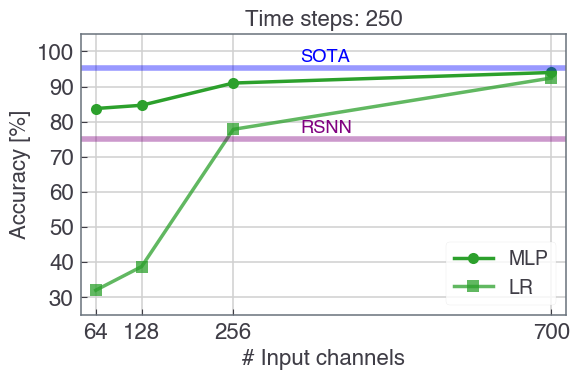

In [ ]:
# Load and plot the results
root = '/content/drive/MyDrive/Colab Notebooks/Delay_computation/Results'
file_name = root + '/MLP_num_channels.plk'

import pickle
dict_load = pickle.load( open( file_name, 'rb' ) )

accs_test_MLP = np.array( dict_load['accs_test'] ).reshape(-1,1)
hidden_size = np.array( dict_load['hidden_size'] )
time_steps = np.array( dict_load['time_steps'] )
num_channels_list = np.array( dict_load['num_channels_list'] )

file_name = root + '/LR_num_channels.plk'
dict_load = pickle.load( open( file_name, 'rb' ) )
accs_test_LR = np.array( dict_load['accs_test'] ).reshape(-1,1)

fig, ax = plt.subplots( figsize=(6, 4) )
ax.plot( num_channels_list, 1e2*np.mean( accs_test_MLP, axis=1 ), color='tab:green', lw=2.5, marker='o', markersize=8, label='MLP' )
ax.plot( num_channels_list, 1e2*np.mean( accs_test_LR, axis=1 )[[3,2,1,0]], color='tab:green', alpha=0.75, lw=2.5, marker='s', markersize=8, label='LR' )
ax.set_xticks( num_channels_list )
ax.hlines( 75.0, -1e5, 1e5, color='purple', alpha=0.4, lw=4 )
ax.hlines( 95.4, -1e5, 1e5, color='blue', alpha=0.4, lw=4 )
ax.set_xlabel( '# Input channels', size=16 )
ax.set_ylabel( 'Accuracy [%]', size=16 )
ax.set_title( f'Time steps: {time_steps}', size=16 )
ax.tick_params( direction='in', labelsize=16, size=4 )
ax.set_xlim( min(num_channels_list)-20, max(num_channels_list)+20 )
ax.set_yticks( np.arange(20, 105, 10) )
ax.set_ylim( 25, 105 )
ax.text( 350, 97, 'SOTA', color='blue' )
ax.text( 350, 77, 'RSNN', color='purple' )
ax.legend( prop={'size':14}, loc=4 )

plt.tight_layout()
fig.savefig( root+'/MLP_LR_num_channels.pdf', dpi=300, transparent=False )

# SHD with CNN
---

In [ ]:
from torchvision.ops.misc import Conv2dNormActivation
from typing import List

In [ ]:
network_params = [ # in_channels, out_channels, kernel_size, kernel_size_pooling
    [ 1,  8, 3, 3],
    [8,  16, 3, 3],
    [16, 32, 3, 3],
    [32, 32, 1, 2],
    [32, 64, 1, 1]
]

class CNN( torch.nn.Module ):
    def __init__(self, network_params):
        super().__init__()
        self.network_params = network_params
        features = [] #List[nn.Module]

        for n, (i, o, k, kp) in enumerate(network_params):
            features.append( Conv2dNormActivation(i, o, k) )
            if n != len(network_params)-1:
                features.append( torch.nn.MaxPool2d( kp ) )
        self.features = nn.Sequential(*features)
        self.linear = nn.Linear( 1024, 20 )

    def forward( self, x ):
        x = torch.unsqueeze( x, 1 )
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.linear(x)
        return x

    def print_out_size(self, x):
        x = torch.unsqueeze( x, 1 )
        x = self.features(x)
        x = torch.flatten(x, 1)
        print(x.shape)


In [ ]:
cnn = CNN( network_params=network_params )

In [ ]:
y = cnn.print_out_size( x_local.to_dense() )
# y.shape

torch.Size([128, 1024])


In [ ]:
def parameter_count_model(model, verbose=True):
    tot_params = 0
    for n, p in model.named_parameters():
        if verbose: print( n + '  ' + str(p.shape) )
        partial = 1
        for num in p.shape:
            partial *= num
        tot_params += partial
    if verbose: print('\nModel parameter count ' + str(tot_params))

parameter_count_model( cnn )

features.0.0.weight  torch.Size([8, 1, 3, 3])
features.0.1.weight  torch.Size([8])
features.0.1.bias  torch.Size([8])
features.2.0.weight  torch.Size([16, 8, 3, 3])
features.2.1.weight  torch.Size([16])
features.2.1.bias  torch.Size([16])
features.4.0.weight  torch.Size([32, 16, 3, 3])
features.4.1.weight  torch.Size([32])
features.4.1.bias  torch.Size([32])
features.6.0.weight  torch.Size([32, 32, 1, 1])
features.6.1.weight  torch.Size([32])
features.6.1.bias  torch.Size([32])
features.8.0.weight  torch.Size([64, 32, 1, 1])
features.8.1.weight  torch.Size([64])
features.8.1.bias  torch.Size([64])
linear.weight  torch.Size([20, 1024])
linear.bias  torch.Size([20])

Model parameter count 29708


In [ ]:
max_time = 1.4
time_steps = 256
dt = max_time/time_steps
batch_size = 128
num_channels = 256
epochs = 60
lr = 1e-3
weight_decay = 1e-4
# Loading the dataset with the desired format/sizes
train_ds, test_ds = get_numpy_datasets(dataset_name='shd', nb_steps=time_steps, n_inp=num_channels)
train_dl = NumpyLoader(train_ds[0], batch_size=batch_size, num_workers=0, drop_last=True)
test_dl = NumpyLoader(test_ds[0], batch_size=batch_size, num_workers=0, drop_last=True)
model = CNN( network_params=network_params ).to(device)
optimizer = torch.optim.Adam( params=model.parameters(), lr=lr, weight_decay=weight_decay )
scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.01, total_iters=10, last_epoch=-1, verbose=False)

[train_losses, train_accs], [test_loss, test_acc] = training_SHD( epochs, model, lr, weight_decay, train_dl, batch_size, test_dl, device,
                                                                    optimizer=optimizer, scheduler=scheduler, verbose=True, keep_2D=True )

Decompressing /root/data/audiospikes/shd_train.h5.gz
Available at: /root/data/audiospikes/shd_train.h5
Available at: /root/data/audiospikes/shd_test.h5
Epoch 1, Train Acc: 57.51, Train Loss: 2.5589
Epoch 2, Train Acc: 82.93, Train Loss: 2.2823
Epoch 3, Train Acc: 90.22, Train Loss: 2.1982
Epoch 4, Train Acc: 94.29, Train Loss: 2.1559
Epoch 5, Train Acc: 96.65, Train Loss: 2.1295
Epoch 6, Train Acc: 97.56, Train Loss: 2.1164
Epoch 7, Train Acc: 98.11, Train Loss: 2.1086
Epoch 8, Train Acc: 98.48, Train Loss: 2.1034
Epoch 9, Train Acc: 98.60, Train Loss: 2.1012
Epoch 10, Train Acc: 98.83, Train Loss: 2.0974
Epoch 11, Train Acc: 98.99, Train Loss: 2.0954
Epoch 12, Train Acc: 99.02, Train Loss: 2.0948
Epoch 13, Train Acc: 99.25, Train Loss: 2.0914
Epoch 14, Train Acc: 99.31, Train Loss: 2.0902
Epoch 15, Train Acc: 99.37, Train Loss: 2.0894
Epoch 16, Train Acc: 99.41, Train Loss: 2.0887
Epoch 17, Train Acc: 99.45, Train Loss: 2.0884
Epoch 18, Train Acc: 99.53, Train Loss: 2.0876
Epoch 19, T

In [ ]:
max_time = 1.4
time_steps = 256
dt = max_time/time_steps
batch_size = 128
num_channels = 256
epochs = 60
lr = 1e-3
weight_decay = 1e-4
# Loading the dataset with the desired format/sizes
train_ds, test_ds = get_numpy_datasets(dataset_name='shd', nb_steps=time_steps, n_inp=num_channels)
train_dl = NumpyLoader(train_ds[0], batch_size=batch_size, num_workers=0, drop_last=True)
test_dl = NumpyLoader(test_ds[0], batch_size=batch_size, num_workers=0, drop_last=True)

reps = 5
test_accs, train_accs = [], []
for i in range(reps):
    model = CNN( network_params=network_params ).to(device)
    optimizer = torch.optim.Adam( params=model.parameters(), lr=lr, weight_decay=weight_decay )
    scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.01, total_iters=10, last_epoch=-1, verbose=False)
    [train_losses, train_acc], [test_loss, test_acc] = training_SHD( epochs, model, lr, weight_decay, train_dl, batch_size, test_dl, device,
                                                                    optimizer=optimizer, scheduler=scheduler, verbose=False, keep_2D=True )
    print(f'CNN, rep {i+1}, Test Acc: {test_acc*100:.2f}%')
    test_accs.append( test_acc )
    train_accs.append( train_acc[-1] )

Available at: /root/data/audiospikes/shd_train.h5
Available at: /root/data/audiospikes/shd_test.h5
CNN, rep 1, Test Acc: 97.31%
CNN, rep 2, Test Acc: 97.36%
CNN, rep 3, Test Acc: 97.14%
CNN, rep 4, Test Acc: 97.49%
CNN, rep 5, Test Acc: 97.52%


In [ ]:
np.mean(test_accs)*100

97.36487746238708

In [ ]:
import pickle
root = '/content/drive/MyDrive/Colab Notebooks/Delay_computation/Results'

dict_results_CNN = {
    'train_accs' : train_accs,
    'test_accs' : test_accs,
    'network_params' : network_params,
    'lr' : lr,
    'weight_decay' : weight_decay,
    'num_channels' : num_channels,
    'time_steps' : time_steps,
}

pickle.dump( dict_results_CNN, open(root+'/CNN_SHD.pkl', 'wb') )

# SHD with RSNN
---

In [ ]:
def exp_convolve(tensor, decay):
    '''
    Filters a tensor with an exponential filter.
    :param tensor: a tensor of shape (trial, time, neuron)
    :param decay: a decay constant of the form exp(-dt/tau) with tau the time constant
    :return: the filtered tensor of shape (trial, time, neuron)

    note that the shape of the tensors is important. You can tho swap the dimentions with the following:
    tensor_swapped = tensor.permute( 1,0,2 ) # dim 0 becomes dim 1 and viceversa, dim 2 not changed
    '''
    #with tf.name_scope('ExpConvolve'):
    #    assert tensor.dtype in [tf.float16, tf.float32, tf.float64]
    r_shp = range(len(tensor.size()))
    transpose_perm = [1, 0] + list(r_shp)[2:]

    tensor_time_major = tensor.permute(transpose_perm)
    initializer = torch.zeros_like(tensor_time_major[0])
    #filtered_tensor = tf.scan(lambda a, x: a * decay + (1 - decay) * x, tensor_time_major, initializer=initializer)
    #########################################################################
    exp_kernel = lambda a, x: a * decay + (1 - decay) * x
    filtered_tensor = []
    tensor_upd = exp_kernel( initializer, tensor_time_major[0] )
    filtered_tensor.append( tensor_upd )
    for i in range( 1, tensor_time_major.size(0) ):
        tensor_upd = exp_kernel( tensor_upd, tensor_time_major[i] )
        filtered_tensor.append( tensor_upd )
    filtered_tensor = torch.stack( filtered_tensor, dim=0 )
    #########################################################################
    filtered_tensor = filtered_tensor.permute(transpose_perm)

    return filtered_tensor